## Hypothesis 8: Rural counties (low population) had less spread

- H0: Population size does not affect the amount of cases
- H1: Lower populations experience fewer cases
- H2: Lower populations experience more cases

### Introduction

Since the virus spreads through contact, we expect counties with larger populations to experience more cases than smaller populations. Since larger populations will almost certainly have more, we use _per-capita_ stats for a fairer comparison of how the populations are affected.

#### Approach
- Relationship between population size and rate of transmission (Rt)
- Skeptical of simple measures to extract Rt directly from raw data
- Instead, use total cases as the result of Rt
- Test using raw and per capita stats, since both have meaning
- Raw: the literal answer to the question: do larger pop. sizes have greater C19 outbreak? We strongly expect yes
- Per capita: besides raw numbers, do the dynamics/characteristics of a larger population encourage greater spread? Less obvious answer.
- Visualize the pop. size vs. cases and pop. size vs. fatalities,  for raw and per capita

In [30]:
# Load packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import re
from scipy.stats import ttest_ind
import matplotlib.patches as mpatches

# Load data
!rm case_clean.csv* test_clean.csv* pop.csv*
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv"
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/fatal_clean.csv"
!wget --no-check-certificate "https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/Population_density.csv" -O pop.csv
!rm counties* County.*
!wget https://opendata.arcgis.com/datasets/9b2eb7d232584572ad53bad41c76b04d_0.zip -O counties.zip
!unzip counties.zip

rm: cannot remove 'test_clean.csv*': No such file or directory
--2020-09-30 20:25:27--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/case_clean.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 264417 (258K) [text/plain]
Saving to: ‘case_clean.csv’

case_clean.csv      100%[===================>] 258.22K   632KB/s    in 0.4s    

2020-09-30 20:25:28 (632 KB/s) - ‘case_clean.csv’ saved [264417/264417]

--2020-09-30 20:25:28--  https://gitlab.tamucc.edu/6380-hypothesis-testing-assignment-3/assignment/-/raw/master/data/fatal_clean.csv
Resolving gitlab.tamucc.edu (gitlab.tamucc.edu)... 64.71.82.39
Connecting to gitlab.tamucc.edu (gitlab.tamucc.edu)|64.71.82.39|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request 

### Data 

**COVID-19 cumulative cases.**
The hypothesis asks what happens to the rate of transmission.
Here, uses cases as a surrogate for the transmission rate. 
There is an obvious relationship between the two; more cases suggest a higher transmission rate. Note that, while supposedly cumulative, the counts occasionally decrease. The `cummax` function is used to force it to be monotic increasing. 

- Source: DSHS, https://dshs.texas.gov/coronavirus/additionaldata.aspx 

**COVID-19 cumulative fatalities.**
The hypothesis asks what happens to the rate of transmission.
Here, also uses fatalities as a surrogate for the transmission rate. 
There is an obvious relationship between the two; more fatalities suggest a higher transmission rate. Note that, while supposedly cumulative, the counts occasionally decrease. The `cummax` function is used to force it to be monotic increasing. 

- Source: DSHS, https://dshs.texas.gov/coronavirus/additionaldata.aspx 


**Texas county populations.** 
The hypothesis asks what affect the population size has. This data is the population for each county. 

- texascounties.net, http://www.texascounties.net/statistics/popdensity2010.htm


In [31]:
# Load data 

# Cumulative cases
dfCase = pd.read_csv("case_clean.csv", index_col = 0)
dfCase_T = dfCase.T
# Cleaning: cumulative must be monotonic increasing
dfCase_T = dfCase_T.cummax()

# Cumulative fatalities
dfFatal = pd.read_csv("fatal_clean.csv", index_col = 0)
dfFatal_T = dfFatal.T
# Cleaning: cumulative must be monotonic increasing
dfFatal_T = dfFatal_T.cummax()

# County populations
dfPop = pd.read_csv("pop.csv", quotechar = '"', skipinitialspace = True)
dfPop = dfPop.replace(',','', regex=True)
dfPop["Population2010"] = dfPop["Population2010"].apply(pd.to_numeric,errors='coerce')
dfPop = dfPop.drop(dfPop.columns[0], axis = 1)
dfPop = dfPop.drop(dfPop.columns[1], axis = 1)
dfPop = dfPop.drop(dfPop.columns[2], axis = 1)
dfPop["Name"] = dfPop["Name"].str.lower()
dfPop.columns = ["name", "pop"]
dfPop.drop(dfPop.tail(1).index, inplace = True)
# Sort by pop size, smallest to largers
dfPop = dfPop.sort_values(by = "pop")

# Texas population
popTexas = dfPop["pop"].sum()

# Counties
counties = list(dfPop["name"])

### Total cases and fatalities 
- raw and _per-capita_

Since transmission rate is not known directly, the simplest measures of spread is total number of cases and fatalities

The following grabs this directly from the cumulative cases/fatalities. It also uses the population size for _per capita_ numbers.

In [32]:
# Find total cases for each county
dfPop["cases"] = [dfCase_T[c][-1] for c in counties]
dfPop["cases_percap"] = dfPop["cases"] / dfPop["pop"] * 1000

# Find total fatalities for each county
dfPop["fatals"] = [dfFatal_T[c][-1] for c in counties]
dfPop["fatals_percap"] = dfPop["fatals"] / dfPop["pop"] * 1000

### Plot total cases vs population size

The hypothesis asks about the relationship between population size and spread of cases. We can look at this with raw or _per-capita_ total cases. Both are meaningful. 

The raw totals describe the exact relationship between population size and cases. We can guess that larger counties would have more cases, just by sheer number of people. But it is worth checking to see if that is the case. There may be outliers such as large counties with very few cases.

However, we are likely interested in the relative spread. As in, do small counties experience not only fewer cases but a smaller proportion of cases. The intuition is that fewer people decrease the chance of contact; thus, the proportional spread is lower. 


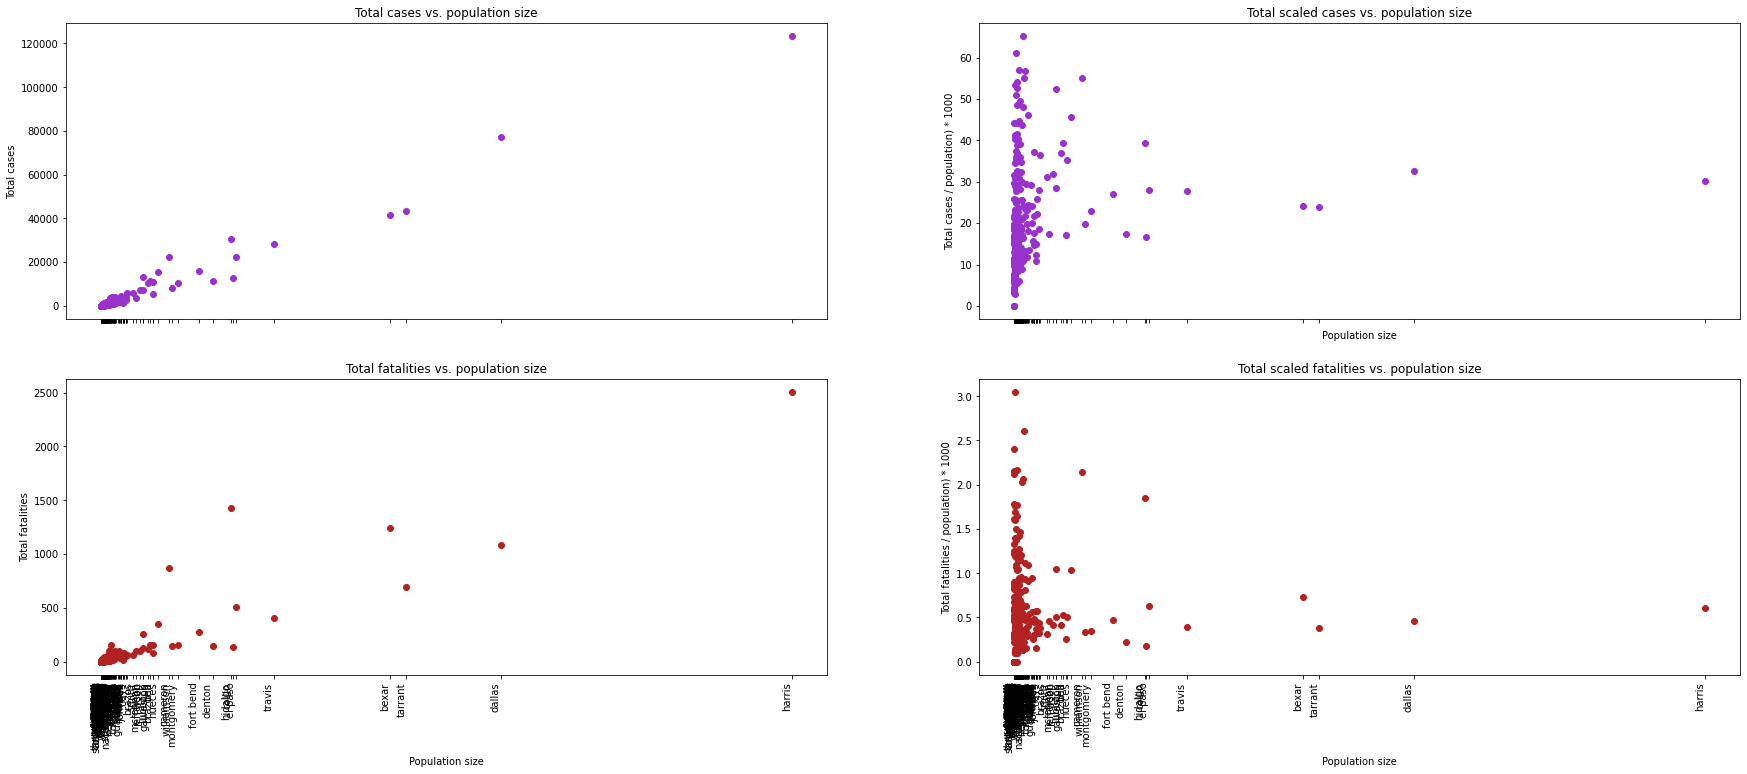

In [33]:
fig, axs = plt.subplots(2, 2, figsize = (30, 12))

# Plot raw total cases vs population size
axs[0][0].scatter(dfPop["pop"], dfPop["cases"], color = "darkorchid");
axs[0][0].set_xticks(dfPop["pop"]);
axs[0][0].set_xticklabels(["" for n in dfPop["name"]], rotation = 90, ha = 'right');
axs[0][0].set_ylabel("Total cases");
axs[0][0].set_title("Total cases vs. population size");

# Plot raw total cases vs population size
axs[1][0].scatter(dfPop["pop"], dfPop["fatals"], color = "firebrick");
axs[1][0].set_xticks(dfPop["pop"]);
axs[1][0].set_xticklabels(dfPop["name"], rotation = 90, ha = 'right');
axs[1][0].set_ylabel("Total fatalities");
axs[1][0].set_xlabel("Population size");
axs[1][0].set_title("Total fatalities vs. population size");

# Plot scaled total cases vs population size
axs[0][1].scatter(dfPop["pop"], dfPop["cases_percap"], color = "darkorchid");
axs[0][1].set_xticks(dfPop["pop"]);
axs[0][1].set_xticklabels(["" for n in dfPop["name"]], rotation = 90, ha = 'right');
axs[0][1].set_ylabel("Total cases / population) * 1000");
axs[0][1].set_xlabel("Population size");
axs[0][1].set_title("Total scaled cases vs. population size");

# Plot raw total cases vs population size
axs[1][1].scatter(dfPop["pop"], dfPop["fatals_percap"], color = "firebrick");
axs[1][1].set_xticks(dfPop["pop"]);
axs[1][1].set_xticklabels(dfPop["name"], rotation = 90, ha = 'right');
axs[1][1].set_ylabel("Total fatalities / population) * 1000");
axs[1][1].set_xlabel("Population size");
axs[1][1].set_title("Total scaled fatalities vs. population size");


### Calculate Pearsons' r correlation
- Total cases vs. population size
-  Total cases vs. population size

In [38]:
from scipy.stats.stats import pearsonr

pearsons_r_raw_cases = pearsonr(dfPop["pop"], dfPop["cases"])
pearsons_r_raw_fatals = pearsonr(dfPop["pop"], dfPop["fatals"])
pearsons_r_percap_cases = pearsonr(dfPop["pop"], dfPop["cases_percap"])
pearsons_r_percap_fatals = pearsonr(dfPop["pop"], dfPop["fatals_percap"])

print("Raw data")
print("\tPearson's r: cases.        coeff = {:.4f},   p-value = {:.10f}".format(pearsons_r_raw_cases[0], pearsons_r_raw_cases[1]))
print("\tPearson's r: fatalities.   coeff = {:.4f},   p-value = {:.10f}".format(pearsons_r_raw_fatals[0], pearsons_r_raw_fatals[1]))
print("\n")
print("Per capita data")
print("\tPearson's r: cases.        coeff = {:.4f},   p-value = {:.10f}".format(pearsons_r_percap_cases[0], pearsons_r_percap_cases[1]))
print("\tPearson's r: fatalities.   coeff = {:.4f},   p-value = {:.10f}".format(pearsons_r_percap_fatals[0], pearsons_r_percap_fatals[1]))



Raw data
	Pearson's r: cases.        coeff = 0.9860,   p-value = 0.0000000000
	Pearson's r: fatalities.   coeff = 0.9166,   p-value = 0.0000000000


Per capita data
	Pearson's r: cases.        coeff = 0.1447,   p-value = 0.0210999801
	Pearson's r: fatalities.   coeff = 0.0049,   p-value = 0.9376284358


### Results

- Very high correlation and significance for raw numbers. As expected, larger counties highly tend to have more cases.
- Very low correlation using per capita. Not at all clear that larger populations will experience the same transmission rate.
- But the above does have a borderline significance for cases. This seems to capture the observation in the plot that there is a threshold where larger counties are never as low-spread as the smallest counties manage. As in, there are tiny counties with little to no cases; the larger counties do not experience this. 

Reject the null hypothesis that population size does not affect spread.

Fail to reject the null hypothesis that population size does not affect the per capita spread.

### Extra: Comparing spikes

**This is something weird that I am trying, don't worry too much about it**

The above considers only the total number at cases. It seems fairly reasonable since a higher spread leads to more cases. 

Another aspect to consider is the spikes. Perhaps a county could be said to experience greater spread if there are greater instances of steep case increases. The rate fluctuates over the time period, so it does not make sense to compare based on a single velocity calculated from the start and end point. 

Instead, the following scores each county based on their steep ascents. 
An edge-detector (savgol filter) is used. This highlights faster rises in the curves, as shown below for 4 selected counties. A _savgol score_ is calculated by summing up the filter's curve whenever it is above the threshold (dotted horizontal line).

To clarify, _savgol score_ is something invented for this analysis. 


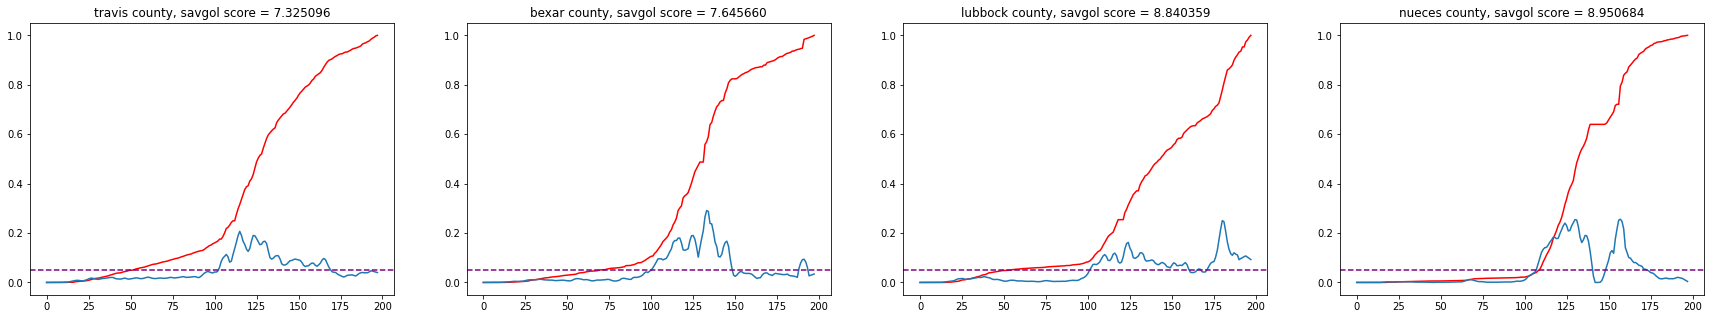

In [35]:
# Plot savgol filter output for 4 selected counties
from scipy.signal import savgol_filter
from sklearn import preprocessing


def pltSF(county, window, axidx):
  normCases = preprocessing.minmax_scale(dfCase_T[county], feature_range = (0, 1), axis = 0, copy = True) 
  sf = savgol_filter(normCases, window_length = window, polyorder = 2, deriv = 1) * 10

  # sf = savgol_filter(dfCase_T[county] / float(dfPop[dfPop["name"] == county]["pop"]) * 1000, window_length=window, polyorder=2, deriv=1) * 10
  # axs[axidx].plot(dfCase_T[county] / float(dfPop[dfPop["name"] == county]["pop"]) * 1000, c = "red");
  
  axs[axidx].plot(normCases, c = "red")
  axs[axidx].plot(sf)
  sfscore = sf[sf > 0.05].sum()
  axs[axidx].set_title("{} county, savgol score = {:.6f}".format(county, sfscore))
  axs[axidx].axhline(0.05, c = "purple", linestyle = "--")


testCounties = ["travis", "bexar", "lubbock", "nueces"]
window = 7

fig, axs = plt.subplots(1, 4, figsize = (30, 5))
for i, c in enumerate(testCounties):
  pltSF(c, window, i)


In [36]:
# Calculate 
window = 7
for county in counties:
  normCases = preprocessing.minmax_scale(dfCase_T[county], feature_range = (0, 1), axis = 0, copy = True) 
  sf = savgol_filter(normCases, window_length = window, polyorder = 2, deriv = 1) * 10
  sfscore = sf[sf > 0.05].sum()
  dfPop.loc[dfPop["name"] == county, "savgol"] = sfscore

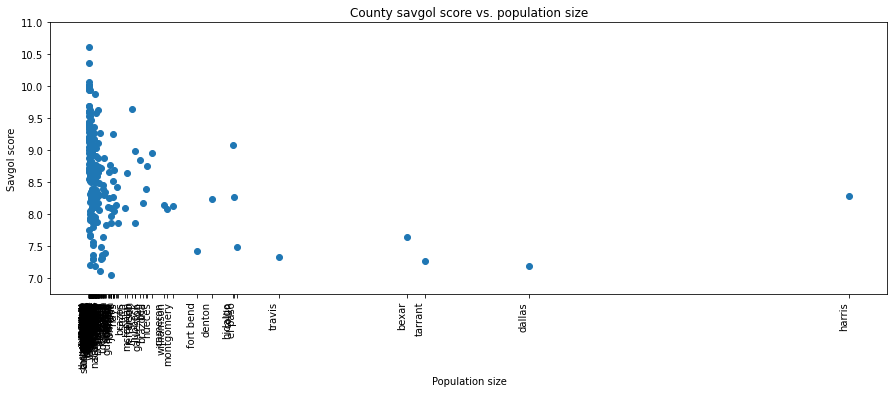

In [37]:
# Plot savgol score
fig, axs = plt.subplots(1, 1, figsize = (15, 5))
axs.scatter(dfPop["pop"], dfPop["savgol"])
axs.set_xticks(dfPop["pop"]);
axs.set_xticklabels(dfPop["name"], rotation = 90, ha = 'right');
axs.set_ylim(6.75, 11);
axs.set_ylabel("Savgol score");
axs.set_xlabel("Population size");
axs.set_title("County savgol score vs. population size");